# Import functions

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed
np.random.seed(1)
torch.manual_seed(1)

# HJ PDE Experiment: 1D Quadratic term with L2 initial data  
$J(x) = \frac{\alpha}{2}\Vert x\Vert^{2}$.

# Parameters of the HJ PDE

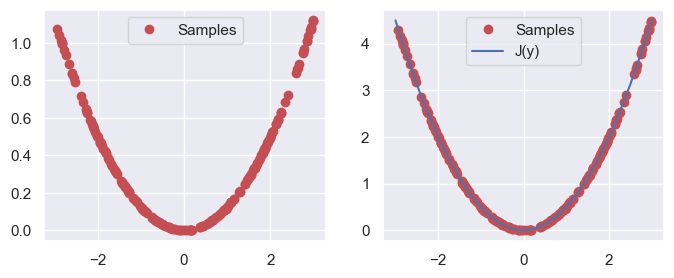

In [22]:
# We consider here the non-convex optimization problem:
# S(y) = min_{x \in \R} \frac{1}{2}(x-y)^{2} + J(x)
# where J(x) = 0.5 * \alpha * ||x||^2.

# This problem admits the explicit solution
# S(y) = 0.5*(y^{2}*alpha/(1+alpha)).

# The proximal operator is given by
# prox_{J}(y) = y/(1+y).

# We'll train a Learned Proximal Network to learn the solution
# of this problem from a set of K samples (yk,S(yk))_{k=1}^{K}.

# Parameters of the HJ PDE
alpha = 1

# Number of samples and range [a,b] from which to sample and plot
K = 200
b = 3
a = -3 


# True solution S(y,t)
def compute_true_solution(y,alpha):
    """
    Inputs:
        y:              ``Spatial" variable of the HJ solution
        alpha:          Regularization parameter

    Outputs:      
        Sy:             Solution to the minplus HJ PDE
    """

    Sy = 0.5*torch.pow(y*alpha/(1+alpha),2)
    return Sy


# Initial data J(y)
def compute_initial_data_minplus(y,alpha):
    """
    Inputs:
        y:              ``Spatial" variable of the HJ solution
        alpha:          Rgularization parameter

    Outputs:      
        Jy:             Value of the initial data of the minplus HJ PDE
    """

    Jy = 0.5*alpha*torch.pow(y,2)
    return Jy

    
# Generate K samples uniformly from [-3,5]
ysamples = a + (b-a)*torch.rand(size=(K,1)) 
Sysamples = compute_true_solution(ysamples,alpha)
Jysamples = compute_initial_data_minplus(ysamples,alpha)

# Compute the true solution S(y)
ytrue = np.linspace(a,b,25)
Sytrue = 0.5*pow(ytrue*alpha/(1+alpha),2)
Jytrue = 0.5*alpha*pow(ytrue,2)

plt.subplot(1,2,1)
plt.plot(ysamples.numpy(),Sysamples.numpy(),'o', color='r',label="Samples");
plt.legend()

plt.subplot(1,2,2)
plt.plot(ysamples.numpy(),Jysamples.numpy(),'o', color='r', label="Samples")
plt.plot(ytrue,Jytrue,'-',label="J(y)")
plt.legend()


# Model parameters

In [23]:
# Default values
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# Create a model
lpn_model = LPN(in_dim = 1, hidden=hidden, layers=layers, beta=beta).to(device)

print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


# Plot function

In [24]:
# Plotting an LPN model
# function to plot learned prox, convex function, original function
def plot_all(model,ysamples,Sysamples,Jysamples,alpha):
    xi = np.linspace(a, b, 300)

    # Compute the learned proximal opertor and convex function.
    prox_y = prox(xi, model)
    c = cvx(xi, model)

    ysamples = ysamples.detach().numpy()
    Sysamples = Sysamples.detach().numpy()
    Jysamples = Jysamples.detach().numpy()

    plt.rcParams["figure.figsize"] = (8, 3)

    # Learned proximal operator
    prox_true = xi/(1+alpha)

    plt.subplot(1, 2, 1)
    plt.plot(xi, prox_y, "--", ms=5, label="LPN")
    plt.plot(xi, prox_true,".", label="True proximal")
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # Convex function
    # Note: The convex function is equal to 0.5*y^2 - S(y,t)
    plt.subplot(1, 2, 2)
    plt.plot(xi, c - c.min(), "--", ms=5, label="Cvx func -- LPN")
    plt.plot(ysamples, 0.5*pow(ysamples,2) - Sysamples, ".", label="Cvx func at samples -- True")
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # # Initial data J(y) evaluate
    # Jyprox = 0.5*np.minimum(pow(prox_y-mu1,2)/sigma1,pow(prox_y-mu2,2)/sigma2)

    # plt.subplot(1, 3, 3)
    # plt.plot(xi,Jyprox,"--", label="Estimated initial data J(y)")
    # plt.plot(ysamples, Jysamples,".", label="True Initial data J(y) at the samples")
    # plt.grid("on")
    # plt.legend()
    # plt.title("Initial data")

    plt.tight_layout()

# Proximal matching loss

In [25]:
# Proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

# Training function

In [26]:
# Defines what is a single iteration in the training of the LPN.xw

def single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss=None):
    input = ysamples
    target = 0.5*(torch.pow(ysamples,2)) - Sysamples
    
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / K  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / K  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item(), "loss_lstar", loss_lstar.item())

# Train

L2 loss

In [27]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-4)
loss_type = 2


# Train for 10000 iterations
for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples,alpha)
# print(
#     "Values at [-3,-2,-1,0,1,2,3]:",
#     lpn_model(
#         torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
#     ).squeeze(1),
# )


iteration 0 loss 0.9511544108390808 loss_lstar 0.9561544060707092
iteration 500 loss 1.4576976299285889 loss_lstar 0.9672223925590515
iteration 1000 loss 1.0274349451065063 loss_lstar 0.9490528106689453
iteration 1500 loss 0.8929430246353149 loss_lstar 0.9443898797035217
iteration 2000 loss 0.8209478259086609 loss_lstar 0.9357552528381348
iteration 2500 loss 0.7634915113449097 loss_lstar 0.930732011795044
iteration 3000 loss 0.7006422281265259 loss_lstar 0.9348482489585876
iteration 3500 loss 0.6291525363922119 loss_lstar 0.9514724612236023
iteration 4000 loss 0.5686490535736084 loss_lstar 0.8694013953208923
iteration 4500 loss 0.5409852266311646 loss_lstar 0.7902587056159973
iteration 5000 loss 0.5293627977371216 loss_lstar 0.7363653779029846
iteration 5500 loss 0.524217426776886 loss_lstar 0.7065724730491638
iteration 6000 loss 0.521824061870575 loss_lstar 0.6939806938171387
iteration 6500 loss 0.5208404064178467 loss_lstar 0.6878310441970825
iteration 7000 loss 0.5201870203018188 lo

KeyboardInterrupt: 

L1 loss

In [20]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
loss_type = 1

# Train for 10000 iterations
for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(20000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples,alpha)

KeyboardInterrupt: 

Proximal matching loss with gamma = 0.1

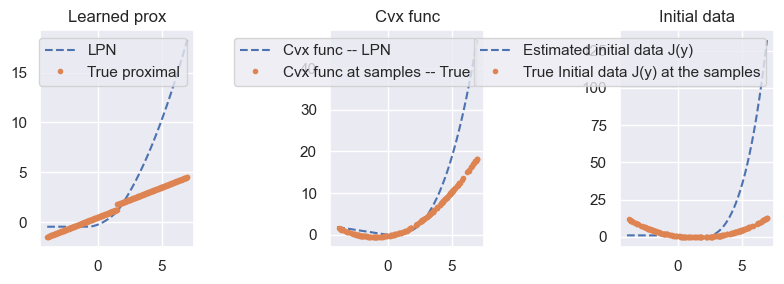

In [43]:
loss_type = 0
gamma_loss = 0.1

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples,alpha)

Proximal matching with gamma = 0.01

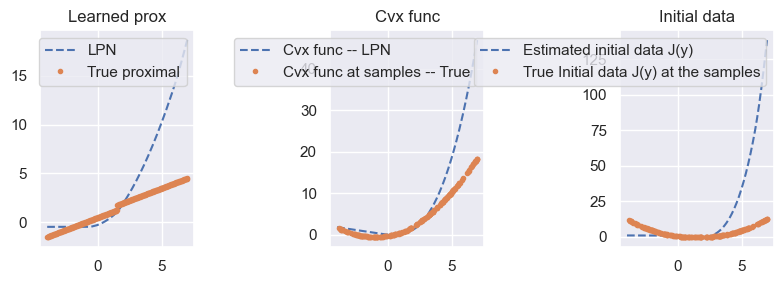

In [44]:
loss_type = 0
gamma_loss = 0.01

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples,alpha)